# Interpretable Microbiome Analysis with the Microbial General Model (MGM)

This Jupyter Notebook provides a comprehensive guide to fine-tuning the Microbial General Model (MGM) on an infant microbiome dataset and extracting interpretable features, such as sample embeddings and attention weights. By following these steps, users can understand how MGM processes microbiome data and use it for classification tasks, such as distinguishing between delivery modes (Cesarean vs. Vaginal) in infant microbiome samples. The notebook is designed for researchers and data scientists interested in microbiome analysis, machine learning, and interpretable AI models.
## Prerequisites

Before starting, ensure you have the required Python packages installed and the example dataset downloaded. The following commands install the necessary libraries and clone the MGM repository, which contains the infant microbiome dataset and pre-trained model resources.

In [1]:
!pip install peft==0.10.0
!pip install accelerate==0.28.0
!pip install microformer-mgm
!pip install numpy==1.25.2
!pip install pandas
!git clone https://github.com/HUST-NingKang-Lab/MGM.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 88.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
microformer-mgm 0.5.8 requires numpy==1.24.3, but you have numpy 2.0.0 which is incompatible.
scikit-learn 1.3.1 requires numpy<2.0,>=1.17.3, but you have numpy 2.0.0 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.0.3 which is incompatible.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.33.3 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.0.1 which is incompatible.
xarray 2025.1.2

## Step 1: Fine-Tuning MGM on the Infant Microbiome Dataset

In this step, we fine-tune the pre-trained MGM model on the infant microbiome dataset to adapt it for a classification task, such as predicting delivery mode (Cesarean or Vaginal). Fine-tuning involves replacing the language modeling head with a classification head and training the model using the provided dataset.

### 1.1 Load Dependencies and Set Configuration

We start by importing necessary modules, setting a random seed for reproducibility, and loading the default configuration for MGM.

In [3]:
from mgm.CLI.CLI_utils import get_CLI_parser, get_CFG_reader, find_pkg_resource
from mgm.src.MicroCorpus import MicroCorpus, MicroTokenizer
from mgm.src.utils import seed_everything, CustomUnpickler
from pickle import load
seed_everything(0)  # set seed
cfg = get_CFG_reader()

No config file provided, use default config file.


### 1.2 Construct the MicroCorpus

The MicroCorpus object processes the microbiome dataset, tokenizes the microbial abundance data, and prepares it for model input. We load the pre-trained MicroTokenizer and use it to construct the corpus from the abundance.csv file.

In [4]:
# load tokenizer
with open(find_pkg_resource("resources/MicroTokenizer.pkl"), "rb") as f:
    unpickler = CustomUnpickler(f)
    tokenizer = unpickler.load()
# construct corpus
corpus = MicroCorpus(
        data_path='MGM/infant_data/abundance.csv',
        tokenizer=tokenizer,
        max_len=cfg.getint("construct", "max_len"),
        preprocess=True,
    )

6 samples are dropped for all zeroes


100%|██████████| 2030/2030 [00:01<00:00, 1413.63it/s]


Total 2030 samples.
            Max length is 60.
            Average length is 20.23152709359606.
            Min length is 3.


###1.3 Fine-Tune the Model

We replace the language modeling head of the pre-trained MGM with a classification head and fine-tune the model using the infant dataset. The dataset is split into training and validation sets, and we use the Trainer API from the transformers library for efficient training.

In [9]:
import pandas as pd
import torch
from torch.utils.data import random_split
from mgm.src.MicroCorpus import SequenceClassificationDataset
from sklearn.preprocessing import OneHotEncoder
from transformers import (
    GPT2ForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from transformers.trainer_callback import EarlyStoppingCallback

labels = pd.read_csv('MGM/infant_data/meta_withbirth.csv', index_col=0)
labels = labels.loc[corpus.data.index]

# label encoding
le = OneHotEncoder()
labels = le.fit_transform(labels.values.reshape(-1, 1)).toarray()
labels = torch.tensor(labels.argmax(axis=1))

# packing into dataset
dataset = SequenceClassificationDataset(
    corpus[:]["input_ids"], corpus[:]["attention_mask"], labels
)

# set model config
model = GPT2ForSequenceClassification.from_pretrained(
    find_pkg_resource('resources/general_model'),
    num_labels=len(le.categories_[0]))

# set training args
training_args = {
    "learning_rate": cfg.getfloat("finetune", "learning_rate"),
    "do_train": True,
    "do_eval": True,
    "group_by_length": True,
    "length_column_name": "length",
    "disable_tqdm": False,
    "lr_scheduler_type": "linear",
    "warmup_steps": cfg.getint("finetune", "warmup_steps"),
    "weight_decay": cfg.getfloat("finetune", "weight_decay"),
    "per_device_train_batch_size": 8,
    "num_train_epochs": cfg.getint("finetune", "num_train_epochs"),
    "save_strategy": "epoch",
    "evaluation_strategy": "epoch",
    "logging_steps": cfg.getint("finetune", "logging_steps"),
    "output_dir": "finetune_checkpoints",
    "logging_dir": 'log',
    "load_best_model_at_end": True,
}

training_args = TrainingArguments(**training_args)

print(f"Start training...")
model = model.train()

split = 0.1

train_size = int(len(corpus) * (1 - split))
val_size = len(corpus) - train_size  # Ensures the sum matches the dataset length
train_set, val_set = random_split(dataset, [train_size, val_size])

callbacks = [EarlyStoppingCallback(early_stopping_patience=10)]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=val_set,
    callbacks=callbacks,
)

trainer.train()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at /usr/local/lib/python3.11/dist-packages/mgm/resources/general_model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Start training...


Epoch,Training Loss,Validation Loss
1,1.623800,1.428349
2,1.159400,1.575478
3,1.179100,1.378390
4,1.199200,1.599443
5,1.019700,1.415767
6,0.991000,1.571033
7,0.984400,1.516824
8,0.702800,1.583256
9,1.062000,1.866027
10,0.530100,1.967636


TrainOutput(global_step=2977, training_loss=0.8860235054460115, metrics={'train_runtime': 497.6356, 'train_samples_per_second': 3671.361, 'train_steps_per_second': 460.176, 'total_flos': 461248025591808.0, 'train_loss': 0.8860235054460115, 'epoch': 13.0})

## Step 2: Extract Sample Embeddings

After fine-tuning, we extract sample embeddings to represent each microbiome sample in a lower-dimensional space. For classification tasks, we use the embedding of the <eos> (end-of-sequence) token as the sample representation.

In [13]:
from tqdm import tqdm
model.cuda()
def cal_embed(input, model):
    input = {k: v.cuda() for k, v in input.items()}
    model.eval()
    embed = model(**input, output_hidden_states=True).hidden_states[-1].squeeze(0)

    # get the last token embedding as the sequence embedding
    mask = input['attention_mask'].squeeze(0)
    embed = embed[mask == 1][-1]
    return embed.detach().cpu().numpy()

labels = pd.read_csv('MGM/infant_data/meta_withbirth.csv', index_col=0)
labels = labels.loc[corpus.data.index]
embed_dict = {labels.index[i]: cal_embed(corpus[i:i+1], model) for i in range(len(corpus))}





  0%|          | 0/2030 [00:00<?, ?it/s]


  0%|          | 8/2030 [00:00<00:25, 78.51it/s]


  1%|          | 16/2030 [00:00<00:26, 76.41it/s]


  1%|          | 25/2030 [00:00<00:25, 78.67it/s]


  2%|▏         | 34/2030 [00:00<00:24, 80.92it/s]


  2%|▏         | 43/2030 [00:00<00:25, 77.88it/s]


  3%|▎         | 52/2030 [00:00<00:25, 79.06it/s]


  3%|▎         | 60/2030 [00:00<00:25, 77.09it/s]


  3%|▎         | 68/2030 [00:00<00:25, 77.66it/s]


  4%|▍         | 77/2030 [00:00<00:24, 78.58it/s]


  4%|▍         | 86/2030 [00:01<00:24, 79.42it/s]


  5%|▍         | 95/2030 [00:01<00:24, 80.10it/s]


  5%|▌         | 104/2030 [00:01<00:23, 81.19it/s]


  6%|▌         | 113/2030 [00:01<00:23, 81.14it/s]


  6%|▌         | 122/2030 [00:01<00:24, 78.47it/s]


  6%|▋         | 131/2030 [00:01<00:23, 79.67it/s]


  7%|▋         | 139/2030 [00:01<00:23, 79.33it/s]


  7%|▋         | 148/2030 [00:01<00:23, 79.73it/s]


  8%|▊         | 157/2030 [00:01<00:23, 80.29it/s]


  8%|▊      


To interpret the embeddings, we reduce their dimensionality using t-SNE and visualize them, coloring points by delivery mode and time point.

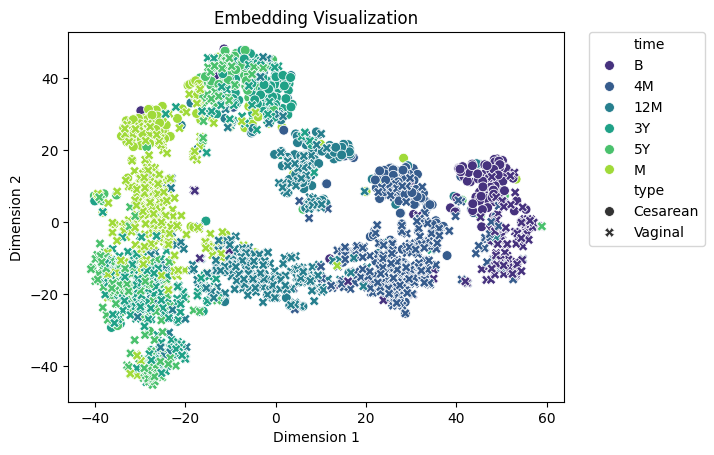

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

embeddings = [embed_dict[key] for key in embed_dict]
embeddings = torch.tensor(embeddings)
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

labels_for_plot = [labels.loc[key]['Env'] for key in embed_dict]

# labels_for_plot = ['Cesarean' if label.endswith('(C)') else 'Vaginal' for label in labels_for_plot]

df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df['label'] = labels_for_plot

# draw a timeline, B < 4M < 12M < 3Y < 5Y <M
timeline = pd.CategoricalDtype(categories=['B', '4M', '12M', '3Y', '5Y', 'M'], ordered=True)
df_c = df[df['label'].str.contains('(C)')]
df_v = df[df['label'].str.contains('(V)')]
df_c['time'] = df_c['label'].apply(lambda x: x.split('(')[0])
df_c['time'] = df_c['time'].astype(timeline)
df_v['time'] = df_v['label'].apply(lambda x: x.split('(')[0])
df_v['time'] = df_v['time'].astype(timeline)
df_c['type'] = 'Cesarean'
df_v['type'] = 'Vaginal'
df_c = df_c.drop(columns=['label'])
df_v = df_v.drop(columns=['label'])
plot_df  = pd.concat([df_c, df_v])

# scatter plot, colored by time, shape by type
sns.scatterplot(data=plot_df, x='x', y='y', hue='time', style='type', s=50, palette='viridis')
plt.title('Embedding Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


##Step 3: Extract Attention Weights

Attention weights indicate the importance of each microbial genus in the model’s classification decisions. We compute these weights for each sample and aggregate them to understand genus-level contributions.

In [49]:
import numpy as np
from tqdm import tqdm

# Initialize attention DataFrame
tokens = corpus.tokens
attn = pd.DataFrame(
    np.zeros((len(corpus.data.index), corpus.tokenizer.vocab_size)),
    index=corpus.data.index,
    columns=tokenizer.vocab.keys(),
    dtype=np.float32
)

# Compute attention weights
for sample in tqdm(range(len(corpus))):
    token = tokens[sample]
    token = token[token != 0]
    input = {k: v.cuda() for k, v in corpus[sample:sample+1].items()}
    model.eval()
    attention = model(**input, output_attentions=True)[-1]
    attention = sum(list(attention))  # Sum over layers
    attention = attention.sum(axis=1).sum(axis=1)  # Sum over heads and tokens
    attn.iloc[sample, token] = attention[0][:len(token)].detach().cpu().numpy()

# Filter out zero columns and special tokens
attn = attn.loc[:, ~(attn == 0).all(axis=0)]
attn = attn.loc[:, ~attn.columns.isin(['<bos>', '<eos>', '<pad>'])]

# Normalize attention weights
attn = attn.div(attn.sum(axis=1), axis=0)

# Calculate genus importance by label
importance = attn.copy()
importance['meta'] = labels.loc[importance.index, 'Env']
mean_imp = importance.groupby('meta').mean()
mean_imp = mean_imp.reset_index().melt(id_vars='meta', var_name='phylum', value_name='importance').dropna()

100%|██████████| 2030/2030 [00:33<00:00, 60.45it/s]


Draw the genus with top 5 attention weights for B(V) as an example

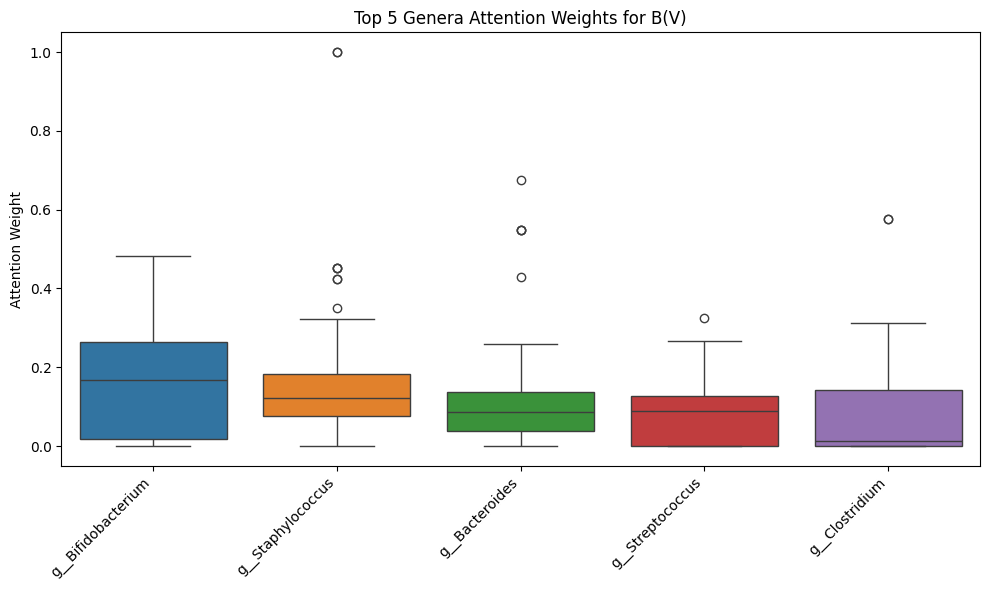

In [50]:
top_genera_BV = importance[importance['meta'] == 'B(V)'].drop(columns=['meta']).mean().nlargest(5).index.tolist()

# Filter the importance DataFrame to include only the top genera and 'B(V)'
filtered_importance = importance[importance['meta'] == 'B(V)'][top_genera_BV]

# Plotting the top genera with their attention weights
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
# boxplot
sns.boxplot(data=filtered_importance)

plt.title('Top 5 Genera Attention Weights for B(V)')
plt.ylabel('Attention Weight')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

##Conclusion

This notebook demonstrates how to:

1. Fine-tune the MGM model on an infant microbiome dataset for classification.

2. Extract and visualize sample embeddings to explore data patterns.

3. Compute and analyze attention weights to identify important microbial genera.

Users can extend this workflow by:

1. Customizing hyperparameters in the configuration file.
2. Applying the model to other microbiome datasets.
3. Exploring additional visualization techniques, such as heatmaps for attention weights.

For further details, refer to the [MGM GitHub repository](https://github.com/HUST-NingKang-Lab/MGM/blob/main/requirements.txt).